# IS ZOC/MCM ROBUST AGAINST CORRUPTIONS
# DO METRICS STILL HOLD

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams['text.usetex'] = True

# Set fonts for Matplotlib
plt.rcParams['font.serif'] = 'Palatino'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.monospace'] = 'Courier'
plt.rcParams['font.size'] = 11
width_cm = 15
height_cm = 8
# Convert centimeters to inches
width_in = width_cm / 2.54
height_in = height_cm / 2.54
import seaborn as sns
sns.set_theme()
figsize= (width_in, height_in)


import os
from metrics.plotting_utils import save_plot, get_history_from_project, save_csv, get_dataset_name_mapping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import wandb
api = wandb.Api()
from ood_detection.config import Config
from datasets.config import DATASETS_DICT
dataset_mapping = get_dataset_name_mapping()

/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Show influence of corruptions on metrics. three small plots

In [2]:
# base metrics
clp = get_history_from_project('thesis-clp-temperature-100runs')
mmd = get_history_from_project('thesis-mmd-100')
zsa_class = tip_df = get_history_from_project('thesis-tip-adapters-16_shots-test')['ZEROSHOT']
clp_one_temp = clp[(clp['temperature'] < 1.13) & (clp['temperature'] > 0.98)]
clp_one_temp = clp_one_temp.drop(['temperature', 'std'], axis=1)
mmd = mmd.drop('std', axis=1)
distances = pd.concat([mmd, clp_one_temp, zsa_class], axis=1).rename(columns={'ZEROSHOT': 'zsa'})

In [3]:
base = distances.copy()
base

,mmd,clp,zsa
name,,,
svhn,0.001023,-0.997723,24.946220
stanford cars,0.004775,-1.494263,59.731377
fashion mnist,0.019312,-1.764627,59.560000
dtd,0.010762,-1.308142,43.882979
imagenet,0.002499,-1.599292,62.840000
cifar10,0.034768,-2.486477,89.830000
mnist,0.003381,-0.954776,48.220000
caltech cub,0.004373,-1.394891,52.157404
gtsrb,0.009100,-1.082986,32.319873


In [4]:
corr_orig = get_history_from_project('thesis-corruption-distances-final', set_name_index=False)


In [5]:
corr_distances = corr_orig.copy()
corr_distances['corruption'] = corr_distances['name'].apply(lambda x: x.split('_')[1])
corr_distances['comboname'] = corr_distances['name'] +  '_' + corr_distances['severity'].astype(str)
corr_distances['name'] = corr_distances['name'].apply(lambda x: x.split('_')[0])
corr_distances = corr_distances.set_index('comboname').drop(['clp_std', 'mmd_std'], axis=1)
for name in corr_distances.name.unique():
    for c in corr_distances.corruption.unique():
        new_values = {}
        index_name = f"{name}_{c}_0"
        new_values['severity']= 0
        new_values['mmd'] = base.loc[name]['mmd']
        new_values['zsa'] =base.loc[name]['zsa'] / 100
        new_values['clp'] = base.loc[name]['clp']
        new_values['name']= name
        new_values['corruption']= c
        corr_distances.loc[index_name]= new_values

In [6]:
corr_distances[corr_distances['severity'] == 0]

,zsa,clp,mmd,severity,name,corruption
comboname,,,,,,
flowers102_Snow_0,0.664498,-1.698843,0.009622,0,flowers102,Snow
flowers102_Brightness_0,0.664498,-1.698843,0.009622,0,flowers102,Brightness
flowers102_Gaussian_0,0.664498,-1.698843,0.009622,0,flowers102,Gaussian
dtd_Snow_0,0.438830,-1.308142,0.010762,0,dtd,Snow
dtd_Brightness_0,0.438830,-1.308142,0.010762,0,dtd,Brightness
dtd_Gaussian_0,0.438830,-1.308142,0.010762,0,dtd,Gaussian
caltech cub_Snow_0,0.521574,-1.394891,0.004373,0,caltech cub,Snow
caltech cub_Brightness_0,0.521574,-1.394891,0.004373,0,caltech cub,Brightness
caltech cub_Gaussian_0,0.521574,-1.394891,0.004373,0,caltech cub,Gaussian


In [7]:
corr_distances.severity.unique()

array([1, 3, 5, 0])

In [8]:
corr_distances.head(1)

,zsa,clp,mmd,severity,name,corruption
comboname,,,,,,
flowers102_Snow_1,0.471947,-1.381472,0.00403,1,flowers102,Snow


### Express increase / decrease in percentual change from origin

In [9]:
# group by name and corruption. take value from 4 and substract 0
from collections import defaultdict
diff_dict = defaultdict(list)
difficulty_metrics = ['zsa', 'mmd', 'clp']
for name, group in corr_distances.groupby(['name', 'corruption']):
    min_df = group[group['severity']==0]
    max_df = group[group['severity']==5]

    for metric in difficulty_metrics:
        diff_dict[metric].append(max_df[metric][0] - min_df[metric][0])

In [10]:
def get_mean_std(dicti, metric):
    print(f"{metric}: mean:{np.mean(dicti[metric])}, std:{np.std(dicti[metric])}")

for metric in difficulty_metrics:
    get_mean_std(diff_dict, metric)

zsa: mean:-0.3890792962964136, std:0.2356435888036264
mmd: mean:-0.006200293752240803, std:0.005523971161038185
clp: mean:0.3273324489593506, std:0.24858593108387297


In [11]:
# 10 reduziert sich um 4, das sind: 4/10= 40%

In [12]:
for metric in difficulty_metrics:
    orig_met = np.abs(base.mean()[metric])
    if metric=='zsa':
        orig_met = orig_met / 100
    change = np.abs(np.mean(diff_dict[metric]))
    print(f"{metric}: orig: {orig_met} to: {orig_met -change}, change: {change} is: {change/orig_met}")


zsa: orig: 0.5728334833860336 to: 0.18375418708962, change: 0.3890792962964136 is: 0.6792188438367042
mmd: orig: 0.011343810090915419 to: 0.005143516338674616, change: 0.006200293752240803 is: 0.546579473964065
clp: orig: 1.5643770198027294 to: 1.2370445708433788, change: 0.3273324489593506 is: 0.20924140716451317


#### --> take flowers brightness (zsa decreases nice), caltech snow (mmd) and caltech gaussian (clp)


In [13]:
mmd_groups = [('caltech101', 'Snow'), ('dtd', 'Gaussian'), ('flowers102', 'Brightness')]
clp_groups = [('flowers102', 'Brightness'), ('caltech cub', 'Gaussian'), ('caltech101', 'Snow')]
zsa_groups = [('caltech cub', 'Brightness'), ('flowers102', 'Gaussian'), ('dtd', 'Snow')]

In [14]:
figsize

(5.905511811023622, 3.149606299212598)

In [15]:
plt.rcParams['font.size'] = 14

Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_3


True

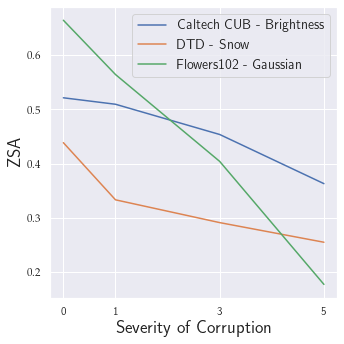

In [16]:
metrix = 'zsa'
fig, ax = plt.subplots(figsize=(5,5))
for name, group in corr_distances[[metrix, 'corruption', 'severity','name']].groupby(['name', 'corruption']):
    if name in zsa_groups:
    # if name:
        g = group.sort_values('severity')
        label_name = f"{dataset_mapping[name[0]]} - {name[1]}"
        ax.plot(g['severity'], g[metrix], label=label_name)
        ax.set_xticks(g['severity'])
        ax.set_xticklabels([0,1,3,5])
ax.set_ylabel(metrix.upper(), fontsize=18)
ax.set_xlabel('Severity of Corruption', fontsize=18)
# ax.set_title('Corruptions - Zero-Shot Accuracy')
ax.legend(fontsize=14)
plt.tight_layout()
save_plot(fig, metrix + 'corrupted', '5_3', False)

Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_3


True

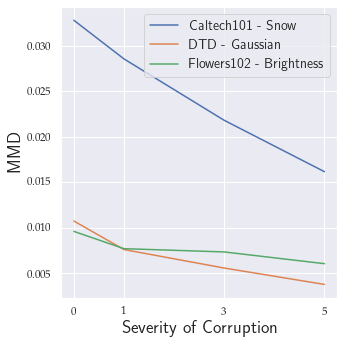

In [17]:
metrix= 'mmd'
fig, ax = plt.subplots(figsize=(5,5))
for name, group in corr_distances[[metrix, 'corruption', 'severity','name']].groupby(['name', 'corruption']):
    if name in mmd_groups:
    # if name:
        g = group.sort_values('severity')
        label_name = f"{dataset_mapping[name[0]]} - {name[1]}"
        ax.plot(g['severity'], g[metrix], label=label_name)
        ax.set_xticks(g['severity'])
        #ax.set_xticklabels([0,1,3,5])
ax.set_ylabel(metrix.upper(), fontsize=18)
ax.set_xlabel('Severity of Corruption', fontsize=18)
# ax.set_title('Corruptions - Maximum Mean Discrepancy')
ax.legend(fontsize=14)
plt.tight_layout()
save_plot(fig, metrix + 'corrupted', '5_3', False)

Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_3


True

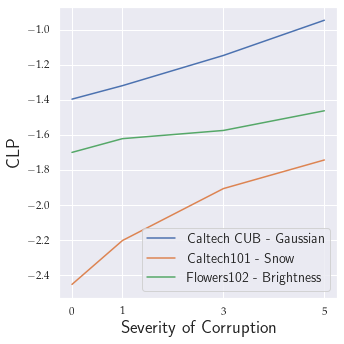

In [18]:
metrix = 'clp'
fig, ax = plt.subplots(figsize=(5,5))
for name, group in corr_distances[[metrix, 'corruption', 'severity','name']].groupby(['name', 'corruption']):
    if name in clp_groups:
    #if name:
        g = group.sort_values('severity')
        label_name = f"{dataset_mapping[name[0]]} - {name[1]}"
        ax.plot(g['severity'], g[metrix], label=label_name)
        ax.set_xticks(g['severity'])
ax.set_ylabel(metrix.upper(), fontsize=18)
ax.set_xlabel('Severity of Corruption', fontsize=18)
# ax.set_title('Corruptions -Confusion Log Probability')
ax.legend(fontsize=14)
plt.tight_layout()
save_plot(fig, metrix + 'corrupted', '5_3', False)

In [19]:
plt.rcParams['font.size'] = 11

Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_3


True

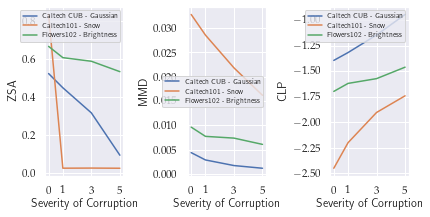

In [20]:
fig, axs = plt.subplots(ncols=3, figsize=figsize)
for i, metrix in enumerate(['zsa', 'mmd', 'clp']):
    ax = axs[i]
    for name, group in corr_distances[[metrix, 'corruption', 'severity','name']].groupby(['name', 'corruption']):
        if name in clp_groups:
        #if name:
            g = group.sort_values('severity')
            label_name = f"{dataset_mapping[name[0]]} - {name[1]}"
            ax.plot(g['severity'], g[metrix], label=label_name)
            ax.set_xticks(g['severity'])
    ax.set_ylabel(metrix.upper())
    ax.set_xlabel('Severity of Corruption')
    # ax.set_title('Corruptions -Confusion Log Probability')
    ax.legend(fontsize=7)
    
    
    
plt.tight_layout()
save_plot(fig, metrix + 'all_three_metrics', '5_3', False)

## 2. Show sample of performance descrease for 1 or 2 datasets. Look how crowded it gets

# show influence on zoc, linear base line and mcm (maybe values, tables)

## 2.1 Show influence with table

In [21]:
og_zoc = get_history_from_project('thesis-corruptions-zoc-final-5', set_name_index=False)
corr_auc = og_zoc.copy()
corr_auc['severity'] = corr_auc['severity'].astype(int)
corr_auc['comboname'] = corr_auc['name'] + '_' + corr_auc['severity'].astype(str)
corr_auc['corruption'] = corr_auc['name'].apply(lambda x: x.split("_")[1])
corr_auc['name'] = corr_auc['name'].apply(lambda x: x.split("_")[0])
corr_auc = corr_auc.set_index('comboname')

In [22]:
# add zoc baselin
# get zoc
columns={'auc-sum': 'ZOC', 'auc-sum-std':'ZOC-std'}
full_zoc_1 = get_history_from_project('thesis-zsoodd_10_runs-std')
working = full_zoc_1.copy()
metric_of_interest = ['auc-sum', 'auc-sum-std']
working_zoc = working[metric_of_interest]

In [23]:
corr_auc.head(3)

,auc-sum-std,auc-max-std,auc-max,auc-sum,f1_mean,acc_mean,auc-mean,severity,f1_mean-std,auc-mean-std,name,corruption
comboname,,,,,,,,,,,,
gtsrb_Snow_1,0.086494,0.043144,0.491916,0.521167,0.639657,0.580285,0.518988,1,0,0.084627,gtsrb,Snow
gtsrb_Snow_3,0.041970,0.040476,0.510665,0.532326,0.707556,0.617577,0.525075,3,0,0.038810,gtsrb,Snow
gtsrb_Snow_5,0.023751,0.019319,0.518398,0.535676,0.734692,0.627791,0.537548,5,0,0.023693,gtsrb,Snow


In [24]:
final_corr = corr_auc.copy()
final_corr = final_corr[[col for col in final_corr.columns if col in ['auc-sum','name', 'auc-sum-std', 'corruption', 'severity']]]
for name in final_corr.name.unique():
    for c in final_corr.corruption.unique():
        new_values = {}
        index_name = f"{name}_{c}_0"
        new_values['severity']= 0
        new_values['auc-sum'] = working_zoc.loc[name]['auc-sum']
        new_values['auc-sum-std'] = working_zoc.loc[name]['auc-sum-std']
        new_values['name']= name
        new_values['corruption']= c
        final_corr.loc[index_name]= new_values

## Plot to group & mean all names or corruptions, best to show a trend!

In [25]:
# make it possible to create plots grouped by a corruption, a name, severity
def plot_grouper_meaner(grouper, df, metric='zoc'):
    
    
    if metric == 'zoc':
        auroc = 'auc-sum'
    else:
        auroc = 'auc-max'
    metric_of_interest = [auroc, auroc+ '-std']
    all_groups = ['corruption','name']
    all_groups.remove(grouper)
    sevs = [0,1,3,5]

    leftover=all_groups[0]
    fig, ax = plt.subplots()
    for name, group in df.groupby(grouper):
        # for corruption
        df = group[[auroc,'severity','name']].sort_values('severity')
        # for each severity sum up all corruption values
        means =[]
        for sev in sevs:
            means.append(df[df['severity']==sev][auroc].mean())
        if grouper== 'name':
            ax.plot(sevs, means, label=dataset_mapping[name])
        else:
            ax.plot(sevs, means, label=name)

    # hline
    ax.hlines(0.5, xmin=0, xmax=len(means)+1, colors='darkgrey', alpha=0.9, linestyles='--', lw=2, label='Uninformed Guesser')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=7)
    plt.subplots_adjust(right=0.75)

    ax.set_xlabel('Severity of Corruption')
    ax.set_ylabel('mean AUROC')
    t = ax.set_xticks(sevs)
    plt.tight_layout()

    save_plot(fig, f'{metric}_grouped_{grouper}_mean_{leftover}', '5_3', False)


/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tikzplotlib/_cleanfigure.py:166: UserWarning: Cleaning Line Collections (scatter plot) is not supported yet.
  warnings.warn(


Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_3


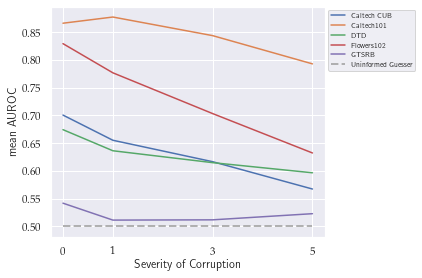

In [26]:
plot_grouper_meaner('name', final_corr)

/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tikzplotlib/_cleanfigure.py:166: UserWarning: Cleaning Line Collections (scatter plot) is not supported yet.
  warnings.warn(


Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_3


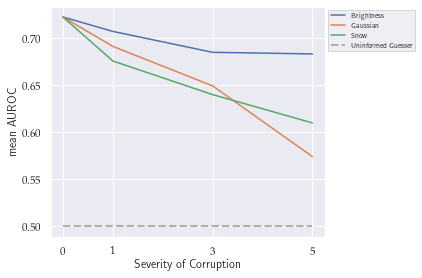

In [27]:
plot_grouper_meaner('corruption', final_corr)

In [28]:
for name, group in final_corr.groupby(['name', 'severity', 'corruption']):
    if name[0] == 'gtsrb':
        if name[2] == 'Brightness':
            print(group)
            print("\n\n")

                    auc-sum-std   auc-sum  severity   name  corruption
comboname                                                             
gtsrb_Brightness_0     0.109549  0.541935         0  gtsrb  Brightness



                    auc-sum-std   auc-sum  severity   name  corruption
comboname                                                             
gtsrb_Brightness_1     0.039949  0.503822         1  gtsrb  Brightness



                    auc-sum-std   auc-sum  severity   name  corruption
comboname                                                             
gtsrb_Brightness_3     0.061279  0.486636         3  gtsrb  Brightness



                    auc-sum-std   auc-sum  severity   name  corruption
comboname                                                             
gtsrb_Brightness_5     0.039706  0.530131         5  gtsrb  Brightness





In [29]:
final_corr.corr()

/tmp/ipykernel_687/2145232938.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  final_corr.corr()


,auc-sum-std,auc-sum,severity
auc-sum-std,1.000000,-0.114935,-0.226907
auc-sum,-0.114935,1.000000,-0.301940
severity,-0.226907,-0.301940,1.000000


## Create monstrum again

In [30]:
full_corruption_zoc = pd.concat([corr_distances, final_corr[['auc-sum', 'auc-sum-std']]], axis=1)

In [31]:
of_interest = ['zsa', 'severity','mmd', 'clp', 'auc-sum','auc-sum-std']
full_corruption_zoc.dropna()[of_interest].corr()['auc-sum'].round(3)

zsa            0.385
severity      -0.302
mmd            0.698
clp           -0.915
auc-sum        1.000
auc-sum-std   -0.115
Name: auc-sum, dtype: float64

## See, where the method breaks (ZOC)

In [32]:
full_corruption_zoc[full_corruption_zoc['name'] == 'gtsrb']

,zsa,clp,mmd,severity,name,corruption,auc-sum,auc-sum-std
comboname,,,,,,,,
gtsrb_Snow_1,0.018052,-1.148726,0.004010,1,gtsrb,Snow,0.521167,0.086494
gtsrb_Snow_3,0.015914,-1.156804,0.002728,3,gtsrb,Snow,0.532326,0.041970
gtsrb_Snow_5,0.015044,-1.021081,0.004213,5,gtsrb,Snow,0.535676,0.023751
gtsrb_Brightness_1,0.022407,-1.136420,0.009945,1,gtsrb,Brightness,0.503822,0.039949
gtsrb_Brightness_3,0.021932,-1.071147,0.010341,3,gtsrb,Brightness,0.486636,0.061279
gtsrb_Brightness_5,0.021536,-1.063961,0.012862,5,gtsrb,Brightness,0.530131,0.039706
gtsrb_Gaussian_1,0.024149,-1.046750,0.010085,1,gtsrb,Gaussian,0.509404,0.078056
gtsrb_Gaussian_3,0.022724,-1.045083,0.006787,3,gtsrb,Gaussian,0.516832,0.060228
gtsrb_Gaussian_5,0.020111,-1.077047,0.002673,5,gtsrb,Gaussian,0.503240,0.043146


In [33]:
threshold = .04
full_corruption_zoc.dropna()[(full_corruption_zoc['auc-sum'] < 0.5 + threshold) & (full_corruption_zoc['auc-sum'] > 0.5-threshold)][of_interest].sort_index()

,zsa,severity,mmd,clp,auc-sum,auc-sum-std
comboname,,,,,,
caltech cub_Gaussian_5,0.092164,5,0.001164,-0.944596,0.523141,0.029001
gtsrb_Brightness_1,0.022407,1,0.009945,-1.136420,0.503822,0.039949
gtsrb_Brightness_3,0.021932,3,0.010341,-1.071147,0.486636,0.061279
gtsrb_Brightness_5,0.021536,5,0.012862,-1.063961,0.530131,0.039706
gtsrb_Gaussian_1,0.024149,1,0.010085,-1.046750,0.509404,0.078056
gtsrb_Gaussian_3,0.022724,3,0.006787,-1.045083,0.516832,0.060228
gtsrb_Gaussian_5,0.020111,5,0.002673,-1.077047,0.503240,0.043146
gtsrb_Snow_1,0.018052,1,0.004010,-1.148726,0.521167,0.086494
gtsrb_Snow_3,0.015914,3,0.002728,-1.156804,0.532326,0.041970


## MLS: Funktioniert 

In [34]:
df_mls = get_history_from_project('thesis-corruptions-mls-1', set_name_index=False)
mls_auc = df_mls.copy()
mls_auc['severity'] = mls_auc['severity'].astype(int)
mls_auc['comboname'] = mls_auc['name'] + '_' + mls_auc['severity'].astype(str)
mls_auc['corruption'] = mls_auc['name'].apply(lambda x: x.split("_")[1])
mls_auc['name'] = mls_auc['name'].apply(lambda x: x.split("_")[0])
mls_auc = mls_auc.set_index('comboname')
full_mls = get_history_from_project('thesis-near-mcm-mls-1.0')
working = full_mls.copy()
metric_of_interest = ['auc-max', 'auc-max-std']
working_mls = working[metric_of_interest]
final_mls = mls_auc.copy()
final_mls = final_mls[[col for col in final_mls.columns if col in ['auc-max','name', 'auc-max-std', 'corruption', 'severity']]]
for name in final_mls.name.unique():
    for c in final_mls.corruption.unique():
        new_values = {}
        index_name = f"{name}_{c}_0"
        new_values['severity']= 0
        new_values['auc-max'] = working_mls.loc[name]['auc-max']
        new_values['auc-max-std'] = working_mls.loc[name]['auc-max-std']
        new_values['name']= name
        new_values['corruption']= c
        final_mls.loc[index_name]= new_values

In [35]:
for name, group in final_mls.groupby(['name', 'severity', 'corruption']):
    if name[0] == 'gtsrb':
        if name[2] == 'Brightness':
            print(group)
            print("\n\n")

                    severity   auc-max  auc-max-std   name  corruption
comboname                                                             
gtsrb_Brightness_0         0  0.566542     0.065261  gtsrb  Brightness



                    severity   auc-max  auc-max-std   name  corruption
comboname                                                             
gtsrb_Brightness_1         1  0.533036     0.065874  gtsrb  Brightness



                    severity   auc-max  auc-max-std   name  corruption
comboname                                                             
gtsrb_Brightness_3         3  0.566645     0.054628  gtsrb  Brightness



                    severity   auc-max  auc-max-std   name  corruption
comboname                                                             
gtsrb_Brightness_5         5  0.515464     0.060588  gtsrb  Brightness





/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tikzplotlib/_cleanfigure.py:166: UserWarning: Cleaning Line Collections (scatter plot) is not supported yet.
  warnings.warn(


Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_3


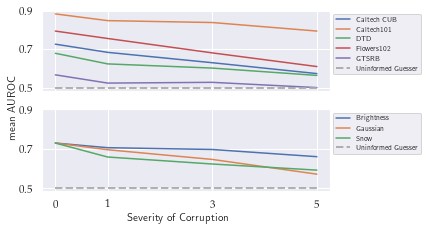

In [36]:
def plot_grouper_meaner_double(groupers, df, metric):
    fig, axs = plt.subplots(nrows=len(groupers), figsize=figsize, sharex=True)

    for i, grouper in enumerate(groupers):
        if metric == 'zoc':
            auroc = 'auc-sum'
        else:
            auroc = 'auc-max'
        metric_of_interest = [auroc, auroc+ '-std']
        all_groups = ['corruption','name']
        all_groups.remove(grouper)
        sevs = [0,1,3,5]

        leftover=all_groups[0]
        for name, group in df.groupby(grouper):
            interm_df = group[[auroc,'severity','name']].sort_values('severity')
            means =[]
            for sev in sevs:
                means.append(interm_df[interm_df['severity']==sev][auroc].mean())
            if i == 0:
                axs[i].plot(sevs, means, label=dataset_mapping[name])
            else:
                axs[i].plot(sevs, means, label=name)
        # set yticks
        axs[i].set_yticks([0.5, 0.7, 0.9])
            

        axs[i].hlines(0.5, xmin=0, xmax=len(means)+1, colors='darkgrey', alpha=0.9, linestyles='--', lw=2, label='Uninformed Guesser')
        axs[i].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=7)

    fig.text(0.4, 0, 'Severity of Corruption', ha='center')
    fig.text(0.0, 0.5, 'mean AUROC', va='center', rotation='vertical')
    
    # set xticks
    plt.xticks([0, 1, 3, 5])

    # set yticks
    plt.yticks([0.5, 0.7, 0.9])
    
    plt.tight_layout()
    save_plot(fig, f'{metric}_grouped_{str(groupers)}_mean', '5_3', False)
    
    
plot_grouper_meaner_double(['name', 'corruption'], final_mls, 'mls')

/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tikzplotlib/_cleanfigure.py:166: UserWarning: Cleaning Line Collections (scatter plot) is not supported yet.
  warnings.warn(


Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_3


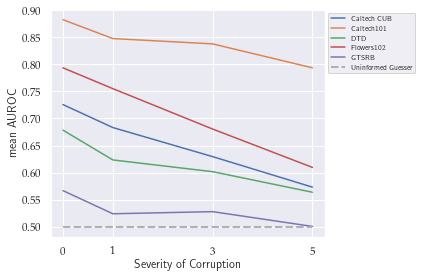

In [37]:
plot_grouper_meaner('name',final_mls, 'mls')

/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tikzplotlib/_cleanfigure.py:166: UserWarning: Cleaning Line Collections (scatter plot) is not supported yet.
  warnings.warn(


Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_3


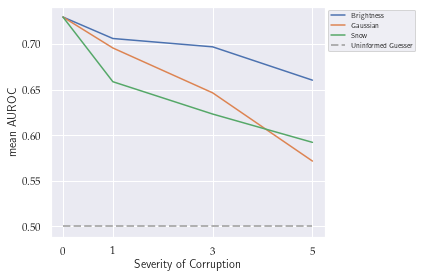

In [38]:
plot_grouper_meaner('corruption',final_mls, 'mls')

In [39]:
full_corruption_df = pd.concat([corr_distances, final_mls[['auc-max', 'auc-max-std']]], axis=1)
of_interest = ['zsa', 'severity','mmd', 'clp', 'auc-max','auc-max-std', 'name', 'corruption']

full_corruption_mls = pd.concat([corr_distances, final_mls[['auc-max', 'auc-max-std']]], axis=1)
threshold = .05
full_corruption_mls.dropna()[(full_corruption_mls['auc-max'] < 0.5 + threshold) & (full_corruption_mls['auc-max'] > 0.5-threshold)][of_interest]

,zsa,severity,mmd,clp,auc-max,auc-max-std,name,corruption
comboname,,,,,,,,
flowers102_Gaussian_5,0.177590,5,0.002212,-1.075036,0.538515,0.026874,flowers102,Gaussian
dtd_Gaussian_5,0.112234,5,0.003799,-0.986858,0.528248,0.059821,dtd,Gaussian
caltech cub_Gaussian_5,0.092164,5,0.001164,-0.944596,0.523431,0.024238,caltech cub,Gaussian
gtsrb_Snow_1,0.018052,1,0.004010,-1.148726,0.529306,0.052564,gtsrb,Snow
gtsrb_Snow_3,0.015914,3,0.002728,-1.156804,0.509076,0.039714,gtsrb,Snow
gtsrb_Snow_5,0.015044,5,0.004213,-1.021081,0.507135,0.067610,gtsrb,Snow
gtsrb_Brightness_1,0.022407,1,0.009945,-1.136420,0.533036,0.065874,gtsrb,Brightness
gtsrb_Brightness_5,0.021536,5,0.012862,-1.063961,0.515464,0.060588,gtsrb,Brightness
gtsrb_Gaussian_1,0.024149,1,0.010085,-1.046750,0.508823,0.069057,gtsrb,Gaussian


In [40]:
full_corruption_df[full_corruption_df['severity'] ==0].sort_values('auc-max')

,zsa,clp,mmd,severity,name,corruption,auc-max,auc-max-std
comboname,,,,,,,,
gtsrb_Snow_0,0.323199,-1.082986,0.009100,0,gtsrb,Snow,0.566542,0.065261
gtsrb_Brightness_0,0.323199,-1.082986,0.009100,0,gtsrb,Brightness,0.566542,0.065261
gtsrb_Gaussian_0,0.323199,-1.082986,0.009100,0,gtsrb,Gaussian,0.566542,0.065261
dtd_Snow_0,0.438830,-1.308142,0.010762,0,dtd,Snow,0.678434,0.037523
dtd_Brightness_0,0.438830,-1.308142,0.010762,0,dtd,Brightness,0.678434,0.037523
dtd_Gaussian_0,0.438830,-1.308142,0.010762,0,dtd,Gaussian,0.678434,0.037523
caltech cub_Snow_0,0.521574,-1.394891,0.004373,0,caltech cub,Snow,0.725746,0.016259
caltech cub_Brightness_0,0.521574,-1.394891,0.004373,0,caltech cub,Brightness,0.725746,0.016259
caltech cub_Gaussian_0,0.521574,-1.394891,0.004373,0,caltech cub,Gaussian,0.725746,0.016259


## MSP

In [41]:
df_msp = get_history_from_project('thesis-corruptions-msp-1', set_name_index=False)
msp_auc = df_msp.copy()
msp_auc['severity'] = msp_auc['severity'].astype(int)
msp_auc['comboname'] = msp_auc['name'] + '_' + msp_auc['severity'].astype(str)
msp_auc['corruption'] = msp_auc['name'].apply(lambda x: x.split("_")[1])
msp_auc['name'] = msp_auc['name'].apply(lambda x: x.split("_")[0])
msp_auc = msp_auc.set_index('comboname')
full_msp = get_history_from_project('thesis-near-mcm-msp-1.0')
working = full_msp.copy()
metric_of_interest = ['auc-max', 'auc-max-std']
working_msp = working[metric_of_interest]
final_msp = msp_auc.copy()
final_msp = final_msp[[col for col in final_msp.columns if col in ['auc-max','name', 'auc-max-std', 'corruption', 'severity']]]
for name in final_msp.name.unique():
    for c in final_msp.corruption.unique():
        new_values = {}
        index_name = f"{name}_{c}_0"
        new_values['severity']= 0
        new_values['auc-max'] = working_msp.loc[name]['auc-max']
        new_values['auc-max-std'] = working_msp.loc[name]['auc-max-std']
        new_values['name']= name
        new_values['corruption']= c
        final_msp.loc[index_name]= new_values

/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tikzplotlib/_cleanfigure.py:166: UserWarning: Cleaning Line Collections (scatter plot) is not supported yet.
  warnings.warn(


Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/tickz/5_3


/home/fmeyer/miniconda3/envs/ood/lib/python3.8/site-packages/tikzplotlib/_cleanfigure.py:166: UserWarning: Cleaning Line Collections (scatter plot) is not supported yet.
  warnings.warn(


Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_3


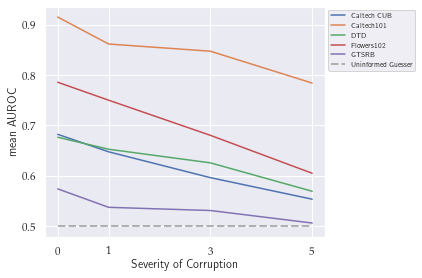

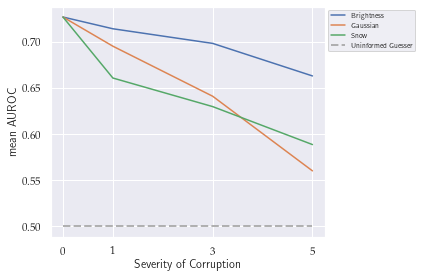

In [42]:
plot_grouper_meaner('name',final_msp, 'msp')
plot_grouper_meaner('corruption',final_msp, 'msp')

In [43]:
full_corruption_msp = pd.concat([corr_distances, final_msp[['auc-max', 'auc-max-std']]], axis=1)
of_interest = ['zsa', 'severity','mmd', 'clp', 'auc-max','auc-max-std', 'name', 'corruption']

full_corruption_finals_mls = pd.concat([corr_distances, final_mls[['auc-max', 'auc-max-std']]], axis=1)


In [44]:
threshold = .03
print('MLS')
full_corruption_mls.dropna()[(full_corruption_mls['auc-max'] < 0.5 + threshold) & (full_corruption_mls['auc-max'] > 0.5-threshold)][of_interest].sort_index()

MLS


,zsa,severity,mmd,clp,auc-max,auc-max-std,name,corruption
comboname,,,,,,,,
caltech cub_Gaussian_5,0.092164,5,0.001164,-0.944596,0.523431,0.024238,caltech cub,Gaussian
dtd_Gaussian_5,0.112234,5,0.003799,-0.986858,0.528248,0.059821,dtd,Gaussian
gtsrb_Brightness_5,0.021536,5,0.012862,-1.063961,0.515464,0.060588,gtsrb,Brightness
gtsrb_Gaussian_1,0.024149,1,0.010085,-1.046750,0.508823,0.069057,gtsrb,Gaussian
gtsrb_Gaussian_3,0.022724,3,0.006787,-1.045083,0.507180,0.059245,gtsrb,Gaussian
gtsrb_Gaussian_5,0.020111,5,0.002673,-1.077047,0.478354,0.044056,gtsrb,Gaussian
gtsrb_Snow_1,0.018052,1,0.004010,-1.148726,0.529306,0.052564,gtsrb,Snow
gtsrb_Snow_3,0.015914,3,0.002728,-1.156804,0.509076,0.039714,gtsrb,Snow
gtsrb_Snow_5,0.015044,5,0.004213,-1.021081,0.507135,0.067610,gtsrb,Snow


In [45]:
print('MSP')
full_corruption_msp.dropna()[(full_corruption_msp['auc-max'] < 0.5 + threshold) & (full_corruption_msp['auc-max'] > 0.5-threshold)][of_interest].sort_index()

MSP


,zsa,severity,mmd,clp,auc-max,auc-max-std,name,corruption
comboname,,,,,,,,
caltech cub_Gaussian_5,0.092164,5,0.001164,-0.944596,0.516486,0.025258,caltech cub,Gaussian
dtd_Gaussian_5,0.112234,5,0.003799,-0.986858,0.521198,0.044030,dtd,Gaussian
gtsrb_Gaussian_3,0.022724,3,0.006787,-1.045083,0.519953,0.051737,gtsrb,Gaussian
gtsrb_Snow_3,0.015914,3,0.002728,-1.156804,0.528514,0.051482,gtsrb,Snow
gtsrb_Snow_5,0.015044,5,0.004213,-1.021081,0.510033,0.065996,gtsrb,Snow


In [46]:
final_corr

,auc-sum-std,auc-sum,severity,name,corruption
comboname,,,,,
gtsrb_Snow_1,0.086494,0.521167,1,gtsrb,Snow
gtsrb_Snow_3,0.041970,0.532326,3,gtsrb,Snow
gtsrb_Snow_5,0.023751,0.535676,5,gtsrb,Snow
gtsrb_Brightness_1,0.039949,0.503822,1,gtsrb,Brightness
gtsrb_Brightness_3,0.061279,0.486636,3,gtsrb,Brightness
gtsrb_Brightness_5,0.039706,0.530131,5,gtsrb,Brightness
caltech cub_Brightness_1,0.021242,0.702286,1,caltech cub,Brightness
caltech cub_Brightness_3,0.027877,0.678856,3,caltech cub,Brightness
caltech cub_Brightness_5,0.018769,0.621397,5,caltech cub,Brightness


In [47]:
pd.concat([full_corruption_msp.rename(columns={'auc-max':'msp', 'auc-max-std': 'msp-std'})[['msp', 'msp-std']], full_corruption_mls.rename(columns={'auc-max':'mls','auc-max-std': 'mls-std'})[['mls', 'mls-std']], ], axis=1).mean()

msp        0.669300
msp-std    0.039044
mls        0.669906
mls-std    0.039452
dtype: float64

In [48]:
mls_msp = pd.concat([full_corruption_msp.rename(columns={'auc-max':'msp', 'auc-max-std': 'msp-std'})[['msp', 'msp-std']], full_corruption_mls.rename(columns={'auc-max':'mls','auc-max-std': 'mls-std'})[['mls', 'mls-std','name']]], axis=1)

In [49]:
mls_msp[['msp', 'mls','name']].groupby('name').corr()

msp       mls
name                               
caltech cub msp  1.000000  0.995651
            mls  0.995651  1.000000
caltech101  msp  1.000000  0.968429
            mls  0.968429  1.000000
dtd         msp  1.000000  0.944104
            mls  0.944104  1.000000
flowers102  msp  1.000000  0.996847
            mls  0.996847  1.000000
gtsrb       msp  1.000000  0.904600
            mls  0.904600  1.000000

## Some hard facts

In [50]:
full_corruption_mls['auc-max'].mean()

0.6699056271547055

In [51]:
full_corruption_mls.groupby(['name', 'severity']).mean().round(3)

/tmp/ipykernel_687/4267317320.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  full_corruption_mls.groupby(['name', 'severity']).mean().round(3)


zsa    clp    mmd  auc-max  auc-max-std
name        severity                                           
caltech cub 0         0.522 -1.395  0.004    0.726        0.016
            1         0.448 -1.300  0.003    0.683        0.016
            3         0.353 -1.175  0.002    0.629        0.018
            5         0.222 -1.062  0.002    0.573        0.019
caltech101  0         0.832 -2.452  0.033    0.883        0.031
            1         0.025 -2.298  0.031    0.848        0.052
            3         0.025 -2.097  0.026    0.838        0.061
            5         0.024 -1.883  0.018    0.794        0.058
dtd         0         0.439 -1.308  0.011    0.678        0.038
            1         0.376 -1.274  0.010    0.623        0.046
            3         0.320 -1.176  0.007    0.602        0.039
            5         0.245 -1.081  0.006    0.564        0.035
flowers102  0         0.664 -1.699  0.010    0.794        0.038
            1         0.547 -1.527  0.006    0.755        0.026
            3         0.453 -1.335  0.005    0.680        0.035
            5         0.325 -1.220  0.004    0.610        0.025
gtsrb       0         0.323 -1.083  0.009    0.567        0.065
            1         0.022 -1.111  0.008    0.524        0.062
            3         0.020 -1.091  0.007    0.528        0.051
            5         0.019 -1.054  0.007    0.500        0.057

In [52]:
full_corruption_mls.groupby('corruption').mean()

/tmp/ipykernel_687/832966609.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  full_corruption_mls.groupby('corruption').mean()


,zsa,clp,mmd,severity,auc-max,auc-max-std
corruption,,,,,,
Brightness,0.358420,-1.519768,0.012229,2.25,0.698117,0.039672
Gaussian,0.283461,-1.398209,0.009706,2.25,0.660762,0.040955
Snow,0.288943,-1.375151,0.009015,2.25,0.650838,0.037730


In [53]:
full_corruption_mls[full_corruption_mls['auc-max'] < 0.6]

,zsa,clp,mmd,severity,name,corruption,auc-max,auc-max-std
comboname,,,,,,,,
flowers102_Snow_5,0.265897,-1.124520,0.002744,5,flowers102,Snow,0.567458,0.027149
flowers102_Gaussian_5,0.177590,-1.075036,0.002212,5,flowers102,Gaussian,0.538515,0.026874
dtd_Snow_1,0.333511,-1.240334,0.008209,1,dtd,Snow,0.595126,0.033121
dtd_Snow_3,0.291489,-1.112360,0.006421,3,dtd,Snow,0.581785,0.039597
dtd_Snow_5,0.255319,-1.041316,0.005317,5,dtd,Snow,0.560426,0.024858
dtd_Gaussian_5,0.112234,-0.986858,0.003799,5,dtd,Gaussian,0.528248,0.059821
caltech cub_Snow_3,0.290818,-1.075388,0.001960,3,caltech cub,Snow,0.592997,0.021169
caltech cub_Snow_5,0.211253,-1.023343,0.001548,5,caltech cub,Snow,0.563256,0.016274
caltech cub_Gaussian_5,0.092164,-0.944596,0.001164,5,caltech cub,Gaussian,0.523431,0.024238


### Now: look, where it breaks. Then, look for MMD, CLP & ZSA there. Theeeen, see if we reached these states with other and what happens

hol dir dir 0.5er indexe from orig. Dann sortier um nach clp. Dann schau, wo die 5er landen.

In [54]:
threshold = 0.05

In [55]:
resetted_index = full_corruption_mls.reset_index()

In [56]:
 resetted_index[(resetted_index['auc-max'] < 0.5+threshold ) & (resetted_index['auc-max'] > 0.5-threshold )].corr().round(2)

/tmp/ipykernel_687/1589628892.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  resetted_index[(resetted_index['auc-max'] < 0.5+threshold ) & (resetted_index['auc-max'] > 0.5-threshold )].corr().round(2)


,zsa,clp,mmd,severity,auc-max,auc-max-std
zsa,1.00,0.40,-0.44,0.46,0.57,-0.59
clp,0.40,1.00,-0.18,0.59,-0.03,-0.11
mmd,-0.44,-0.18,1.00,-0.39,0.03,0.71
severity,0.46,0.59,-0.39,1.00,-0.19,-0.41
auc-max,0.57,-0.03,0.03,-0.19,1.00,-0.14
auc-max-std,-0.59,-0.11,0.71,-0.41,-0.14,1.00


In [57]:
resetted_index[(resetted_index['auc-max'] < 0.5+threshold ) & (resetted_index['auc-max'] > 0.5-threshold )]

,comboname,zsa,clp,mmd,severity,name,corruption,auc-max,auc-max-std
8,flowers102_Gaussian_5,0.177590,-1.075036,0.002212,5,flowers102,Gaussian,0.538515,0.026874
17,dtd_Gaussian_5,0.112234,-0.986858,0.003799,5,dtd,Gaussian,0.528248,0.059821
26,caltech cub_Gaussian_5,0.092164,-0.944596,0.001164,5,caltech cub,Gaussian,0.523431,0.024238
36,gtsrb_Snow_1,0.018052,-1.148726,0.004010,1,gtsrb,Snow,0.529306,0.052564
37,gtsrb_Snow_3,0.015914,-1.156804,0.002728,3,gtsrb,Snow,0.509076,0.039714
38,gtsrb_Snow_5,0.015044,-1.021081,0.004213,5,gtsrb,Snow,0.507135,0.067610
39,gtsrb_Brightness_1,0.022407,-1.136420,0.009945,1,gtsrb,Brightness,0.533036,0.065874
41,gtsrb_Brightness_5,0.021536,-1.063961,0.012862,5,gtsrb,Brightness,0.515464,0.060588
42,gtsrb_Gaussian_1,0.024149,-1.046750,0.010085,1,gtsrb,Gaussian,0.508823,0.069057
43,gtsrb_Gaussian_3,0.022724,-1.045083,0.006787,3,gtsrb,Gaussian,0.507180,0.059245


In [58]:
resetted_index.corr()['auc-max'].round(2)

/tmp/ipykernel_687/2229170974.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  resetted_index.corr()['auc-max'].round(2)


zsa            0.41
clp           -0.92
mmd            0.72
severity      -0.37
auc-max        1.00
auc-max-std   -0.11
Name: auc-max, dtype: float64

In [59]:
below_threshold = resetted_index[(resetted_index['auc-max'] < 0.5+threshold ) & (resetted_index['auc-max'] > 0.5-threshold )].index.values.astype(int)

In [60]:
below_threshold # indices from 0.5er

array([ 8, 17, 26, 36, 37, 38, 39, 41, 42, 43, 44])

In [61]:
resort = full_corruption_mls.reset_index().sort_values('mmd', ascending=True).reset_index()
indice = []
for b in below_threshold:
    # such im resorteten nach dem alten index b. hol dir davon den neuen Index, der Position in MMD Sortierung zeigt
    rb = resort[resort['index'] == b].index.values.astype(int)[0]
    indice.append(rb)
resort.loc[indice].sort_index()

,index,comboname,zsa,clp,mmd,severity,name,corruption,auc-max,auc-max-std
0,26,caltech cub_Gaussian_5,0.092164,-0.944596,0.001164,5,caltech cub,Gaussian,0.523431,0.024238
4,8,flowers102_Gaussian_5,0.177590,-1.075036,0.002212,5,flowers102,Gaussian,0.538515,0.026874
8,44,gtsrb_Gaussian_5,0.020111,-1.077047,0.002673,5,gtsrb,Gaussian,0.478354,0.044056
9,37,gtsrb_Snow_3,0.015914,-1.156804,0.002728,3,gtsrb,Snow,0.509076,0.039714
14,17,dtd_Gaussian_5,0.112234,-0.986858,0.003799,5,dtd,Gaussian,0.528248,0.059821
16,36,gtsrb_Snow_1,0.018052,-1.148726,0.004010,1,gtsrb,Snow,0.529306,0.052564
18,38,gtsrb_Snow_5,0.015044,-1.021081,0.004213,5,gtsrb,Snow,0.507135,0.067610
27,43,gtsrb_Gaussian_3,0.022724,-1.045083,0.006787,3,gtsrb,Gaussian,0.507180,0.059245
40,39,gtsrb_Brightness_1,0.022407,-1.136420,0.009945,1,gtsrb,Brightness,0.533036,0.065874
41,42,gtsrb_Gaussian_1,0.024149,-1.046750,0.010085,1,gtsrb,Gaussian,0.508823,0.069057


In [62]:
resort = full_corruption_mls.reset_index().sort_values('zsa', ascending=True).reset_index()
indice = []
for b in below_threshold:
    rb = resort[resort['index'] == b].index.values.astype(int)[0]
    indice.append(rb)
resort.loc[indice].sort_index()

,index,comboname,zsa,clp,mmd,severity,name,corruption,auc-max,auc-max-std
0,38,gtsrb_Snow_5,0.015044,-1.021081,0.004213,5,gtsrb,Snow,0.507135,0.067610
1,37,gtsrb_Snow_3,0.015914,-1.156804,0.002728,3,gtsrb,Snow,0.509076,0.039714
2,36,gtsrb_Snow_1,0.018052,-1.148726,0.004010,1,gtsrb,Snow,0.529306,0.052564
3,44,gtsrb_Gaussian_5,0.020111,-1.077047,0.002673,5,gtsrb,Gaussian,0.478354,0.044056
4,41,gtsrb_Brightness_5,0.021536,-1.063961,0.012862,5,gtsrb,Brightness,0.515464,0.060588
6,39,gtsrb_Brightness_1,0.022407,-1.136420,0.009945,1,gtsrb,Brightness,0.533036,0.065874
7,43,gtsrb_Gaussian_3,0.022724,-1.045083,0.006787,3,gtsrb,Gaussian,0.507180,0.059245
12,42,gtsrb_Gaussian_1,0.024149,-1.046750,0.010085,1,gtsrb,Gaussian,0.508823,0.069057
18,26,caltech cub_Gaussian_5,0.092164,-0.944596,0.001164,5,caltech cub,Gaussian,0.523431,0.024238
19,17,dtd_Gaussian_5,0.112234,-0.986858,0.003799,5,dtd,Gaussian,0.528248,0.059821


In [63]:
resort = full_corruption_mls.reset_index().sort_values('clp', ascending=False).reset_index()
indice = []
for b in below_threshold:
    rb = resort[resort['index'] == b].index.values.astype(int)[0]
    indice.append(rb)
resort.loc[indice].sort_index()

,index,comboname,zsa,clp,mmd,severity,name,corruption,auc-max,auc-max-std
0,26,caltech cub_Gaussian_5,0.092164,-0.944596,0.001164,5,caltech cub,Gaussian,0.523431,0.024238
1,17,dtd_Gaussian_5,0.112234,-0.986858,0.003799,5,dtd,Gaussian,0.528248,0.059821
2,38,gtsrb_Snow_5,0.015044,-1.021081,0.004213,5,gtsrb,Snow,0.507135,0.067610
5,43,gtsrb_Gaussian_3,0.022724,-1.045083,0.006787,3,gtsrb,Gaussian,0.507180,0.059245
6,42,gtsrb_Gaussian_1,0.024149,-1.046750,0.010085,1,gtsrb,Gaussian,0.508823,0.069057
7,41,gtsrb_Brightness_5,0.021536,-1.063961,0.012862,5,gtsrb,Brightness,0.515464,0.060588
9,8,flowers102_Gaussian_5,0.177590,-1.075036,0.002212,5,flowers102,Gaussian,0.538515,0.026874
11,44,gtsrb_Gaussian_5,0.020111,-1.077047,0.002673,5,gtsrb,Gaussian,0.478354,0.044056
17,39,gtsrb_Brightness_1,0.022407,-1.136420,0.009945,1,gtsrb,Brightness,0.533036,0.065874
20,36,gtsrb_Snow_1,0.018052,-1.148726,0.004010,1,gtsrb,Snow,0.529306,0.052564


## ZOC VS MLS

In [64]:
def plot_errorbar(df, value_column):
    error_corr = .5 * df[value_column + '-std']
    lower = df[value_column] - error_corr
    upper = df[value_column] + error_corr
    if value_column=='auc-max':
        name= 'MCM'
    else:
        name='ZOC'
    # mean = df[value_column].mean().round(3)
    # std = u"\u00B1{})".format(df[value_column+'-std'].mean().round(2))
    # label = name + f' (\u03bc= {mean}' + std
    label = name
    ax.plot(df[value_column], label = label)
    ax.plot(lower, color='tab:blue', alpha=.1)
    ax.plot(upper, color='tab:blue', alpha=.1)
    ax.fill_between(range(len(df)), lower, upper, alpha=.3)

In [65]:
zoc_mls = pd.concat([full_corruption_zoc[['auc-sum', 'auc-sum-std']], full_corruption_mls[['auc-max', 'auc-max-std', 'name', 'corruption','severity']]],axis=1).dropna().sort_index()

/tmp/ipykernel_687/2593258586.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([ticks[i]+" / "+cotick[i] for i in range(len(zoc_mls))], rotation=90, ha='right')


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Tikzplotlib failed could not convert string to float: 'caltech cub_Brightness_0'
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/svg/5_3
Saved to /mnt/c/Users/fmeyer/Git/ood-detection/data/plots/5_3


True

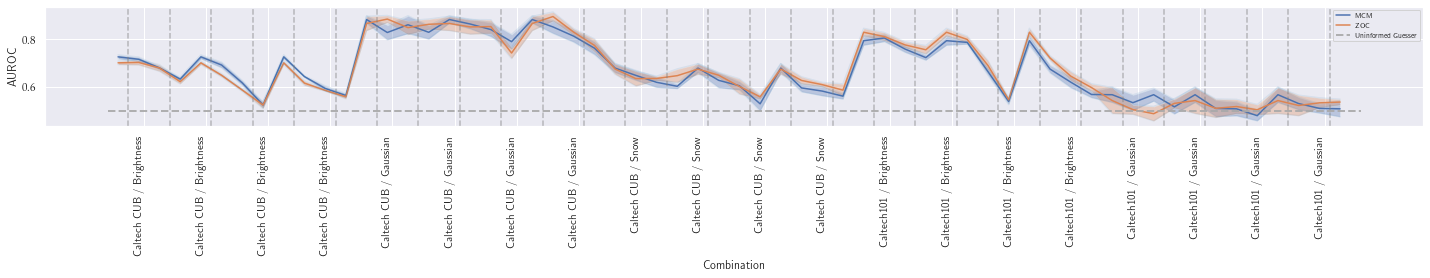

In [66]:
fig, ax = plt.subplots(figsize=(20,4))
plot_errorbar(zoc_mls, 'auc-max')
plot_errorbar(zoc_mls, 'auc-sum')
ax.hlines(0.5, xmin=-.5, xmax=[len(zoc_mls)], colors='darkgrey', alpha=0.9, linestyles='--', lw=2, label='Uninformed Guesser')
ticks = [dataset_mapping[col.split("_")[0]] for col in zoc_mls.index]
cotick = [col.split("_")[1] for col in zoc_mls.index]
_ = ax.set_xticklabels([ticks[i]+" / "+cotick[i] for i in range(len(zoc_mls))], rotation=90, ha='right')
ax.legend(fontsize=7)
ax.set_ylabel('AUROC')
ax.set_xlabel('Combination')
xticks = ax.get_xticks()
print(xticks)
for xtick in xticks[::2]:
    ax.axvline(x=xtick+0.5, color='gray', linestyle='--', alpha=0.5)
xticks = [i + 0.25 for i in range(1, len(xticks), 3)]
_ = ax.set_xticks(xticks)
plt.tight_layout()
save_plot(fig, 'corruption_zoc_mcm', '5_3', False)

In [67]:
zoc_mls[zoc_mls['auc-sum']<0.53][['auc-max', 'auc-sum', 'auc-sum-std'] ]

,auc-max,auc-sum,auc-sum-std
comboname,,,
caltech cub_Gaussian_5,0.523431,0.523141,0.029001
gtsrb_Brightness_1,0.533036,0.503822,0.039949
gtsrb_Brightness_3,0.566645,0.486636,0.061279
gtsrb_Gaussian_1,0.508823,0.509404,0.078056
gtsrb_Gaussian_3,0.507180,0.516832,0.060228
gtsrb_Gaussian_5,0.478354,0.503240,0.043146
gtsrb_Snow_1,0.529306,0.521167,0.086494


In [68]:
zoc_mls.mean().round(3)

/tmp/ipykernel_687/620064080.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  zoc_mls.mean().round(3)


auc-sum        0.674
auc-sum-std    0.041
auc-max        0.670
auc-max-std    0.039
severity       2.250
dtype: float64

In [69]:
zoc_mls.corr().round(3)

/tmp/ipykernel_687/3563500934.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  zoc_mls.corr().round(3)


,auc-sum,auc-sum-std,auc-max,auc-max-std,severity
auc-sum,1.000,-0.115,0.976,-0.087,-0.302
auc-sum-std,-0.115,1.000,-0.067,0.548,-0.227
auc-max,0.976,-0.067,1.000,-0.105,-0.368
auc-max-std,-0.087,0.548,-0.105,1.000,0.015
severity,-0.302,-0.227,-0.368,0.015,1.000


In [70]:
zoc_mls[['auc-max', 'auc-sum']].mean().round(3)

auc-max    0.670
auc-sum    0.674
dtype: float64

In [71]:
zoc_mls[['auc-max', 'auc-sum']].std().round(3)

auc-max    0.120
auc-sum    0.124
dtype: float64

In [72]:
zoc_mls[['auc-max', 'auc-sum','name']].groupby('name').corr()

auc-max   auc-sum
name                                   
caltech cub auc-max  1.000000  0.983611
            auc-sum  0.983611  1.000000
caltech101  auc-max  1.000000  0.744742
            auc-sum  0.744742  1.000000
dtd         auc-max  1.000000  0.936755
            auc-sum  0.936755  1.000000
flowers102  auc-max  1.000000  0.991453
            auc-sum  0.991453  1.000000
gtsrb       auc-max  1.000000  0.252420
            auc-sum  0.252420  1.000000

In [73]:
zoc_mls[['auc-max', 'auc-sum','corruption']].groupby('corruption').corr()

auc-max   auc-sum
corruption                            
Brightness auc-max  1.000000  0.972456
           auc-sum  0.972456  1.000000
Gaussian   auc-max  1.000000  0.983008
           auc-sum  0.983008  1.000000
Snow       auc-max  1.000000  0.979668
           auc-sum  0.979668  1.000000

In [74]:
zoc_mls[['auc-max', 'auc-sum','severity']].groupby('severity').corr()

auc-max   auc-sum
severity                            
0        auc-max  1.000000  0.983057
         auc-sum  0.983057  1.000000
1        auc-max  1.000000  0.977051
         auc-sum  0.977051  1.000000
3        auc-max  1.000000  0.972447
         auc-sum  0.972447  1.000000
5        auc-max  1.000000  0.978328
         auc-sum  0.978328  1.000000